# Временные ряды 5. Поиск аномалий и особенные случаи обработки  

Временные ряды - процесс, который идет шаг за шагом. Порядок постоянен или предсказуем. Однако, иногда что-то идет не так. Котенок не  бегает за бантиком. Вопрос - это только сегодня или теперь так будет всегда? Если всегда, то идем менять модель (кот вырос). Если только сейчас, то это аномалия. Аномалии интересны, но опасны.

Попробуем разобраться аномалиями. Вспомним пример аварии в потреблении энергии и попробуем его узнать автоматически.      


## Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [173]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

Загрузим файл с данными и посмотрим на таблицу их организующую.

## Brent 2010-2019
Перейдем ко второму примеру. Цена нефти марки Brent. Данные по дням от 2010 до 2019 . Данные были обработаны, но не меняли основное содержание ключевого признака. Отличие от исходного описания - дополнение признаками по календарю, как и в первом примере.

In [174]:

path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [175]:
brent_data = brent_data.copy().resample('W').mean()
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000


Общий вид изменения цены по ряду приведен на рис.2.

Text(0.5, 0, 't')

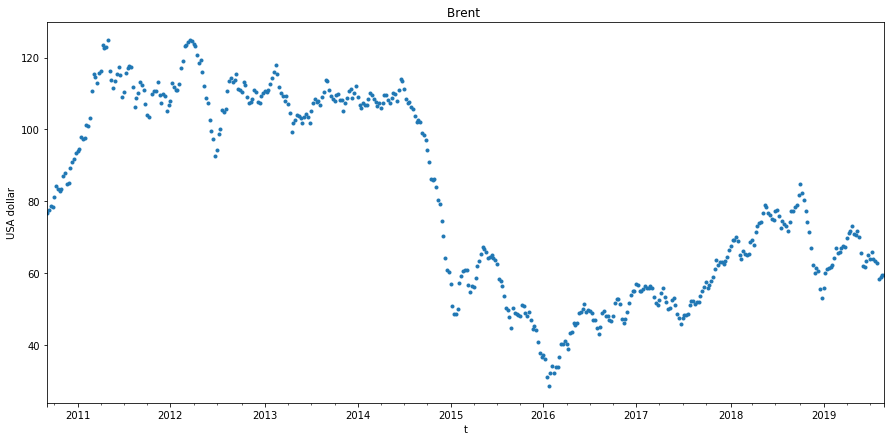

In [176]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

Рис.3 Цена нефти с 2010 по 2019

Помним, что наиболее интересным для и интерпретируемым у этого ряда является поведение его первых разностей
Построим их и посмотрим на аномалии этой части нашей модели.

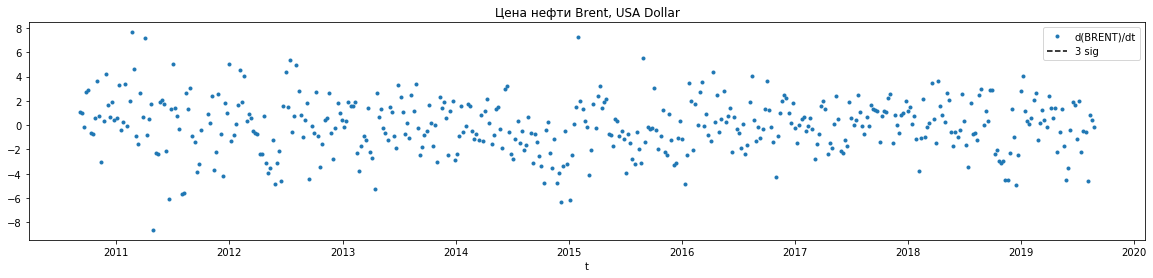

In [177]:
d_brent_data = brent_data['Значение'].values[1:]- brent_data['Значение'].values[:-1]
s_brent = np.std(d_brent_data) *3
plt.figure(figsize=(20,4))
plt.plot(brent_data.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent = np.where( abs(d_brent_data)>s_brent)[0]



Рис.4 BRENT первые разности

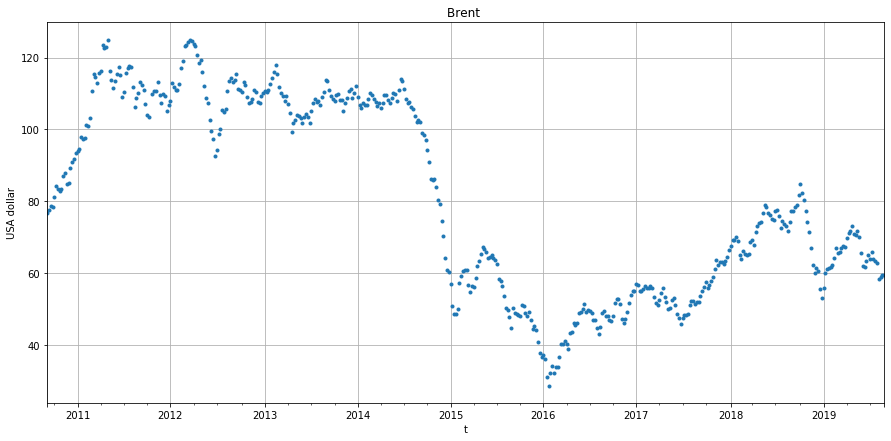

In [178]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(brent_data.iloc[ind_anomal_brent].index,brent_data['Значение'].values[ind_anomal_brent],'*k', label='BRENT anomaly')
plt.ylabel('USA dollar')
plt.grid()
plt.xlabel('t')
plt.show()

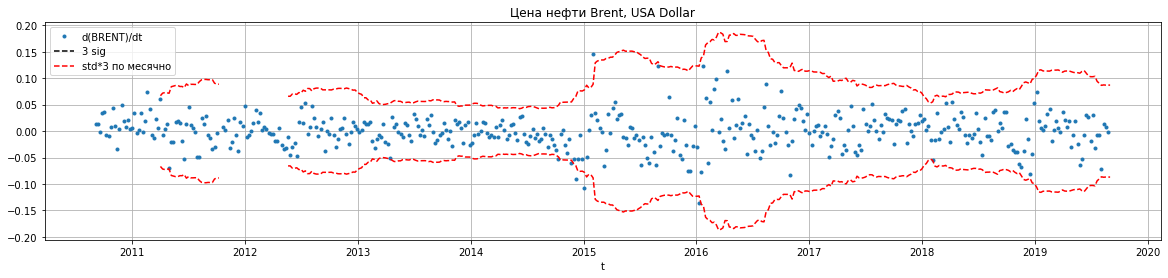

In [179]:
d_brent_data1 = (brent_data['Значение'].values[1:]- brent_data['Значение'].values[:-1])/brent_data['Значение'].values[:-1]
std_d_brent = pd.DataFrame(data=d_brent_data1,index =brent_data.index[1:] ).rolling(30).std()
s_brent1 = np.std(d_brent_data1)*3 
plt.figure(figsize=(20,4))
plt.plot(brent_data.iloc[:-1].index,d_brent_data1,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent1, s_brent1],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent1, -s_brent1],'--k')
plt.plot(std_d_brent.index,std_d_brent*3,'--r',label = 'std*3 по месячно')
plt.plot(std_d_brent.index,-std_d_brent*3,'--r')
plt.xlabel('t')
plt.legend()
plt.grid()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent1 = np.where( abs(d_brent_data1)>s_brent1)[0]
ind_anomal_brent2 = np.where( abs(d_brent_data1)>std_d_brent.values)[0]

In [180]:
brent_data.index[[0,-1]]

DatetimeIndex(['2010-09-05', '2019-09-01'], dtype='datetime64[ns]', name='Дата', freq=None)

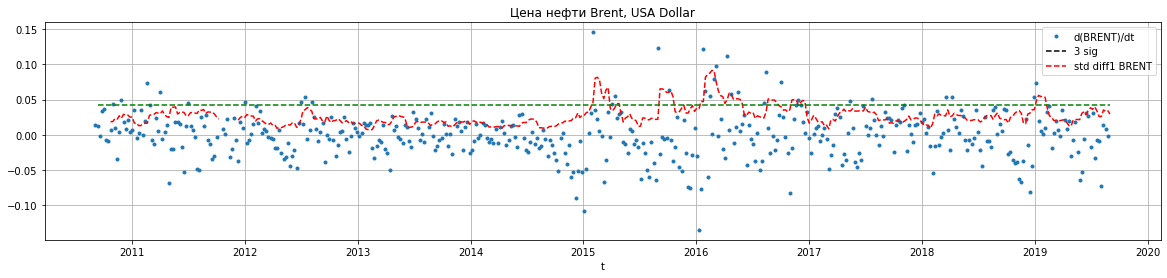

In [181]:
brent_diff1=pd.DataFrame(data=d_brent_data1, index=brent_data.index[1:])

brent_diff1_std=brent_diff1[0].rolling(7).std()
brent_diff_std=np.std(brent_diff1_std)*3

ind_anomal_brent2 = np.where( abs(brent_diff1_std)>brent_diff_std)[0]

plt.figure(figsize=(20,4))
plt.plot(brent_data.iloc[:-1].index,d_brent_data1,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent1, s_brent1],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent1, -s_brent1],'--k')
plt.plot(brent_diff1_std,'--r',label ='std diff1 BRENT')
plt.plot(brent_diff1_std.iloc[[0,-1]].index,[brent_diff_std,brent_diff_std],'--g')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()


In [182]:
brent_diff_std

0.04287925823020487

In [183]:
p =3

#добавляем историю длиной р
for i in range(p):
    brent_data['t'+str(p-i+1)]=0
    brent_data['t'+str(p-i+1)].values[p+2:] = brent_data['Значение'].values[i+1:-(p-i+1)]
for i in range(p):
    brent_data['d'+str(p-i+1)]=0    
    brent_data['d'+str(p-i+1)].values[i+1:] =( (brent_data['Значение'].values[i+1:]- brent_data['Значение'].values[i:-1]))


In [184]:

X = brent_data.iloc[p+2:,:].values

Xscale = scl.fit_transform(X)

clast = DBSCAN(eps=2.9, leaf_size=1, min_samples = 3)
X_scale_clast =clast.fit_predict(Xscale)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [185]:
# не шум, но кластер со смыслом
ind_= np.where(X_scale_clast !=-1)[0]
print('первый элемент кластера',X_scale_clast[ind_[0]],' : ',clast.components_[0])
print('Число кластеров с масштабированием: ',len(np.unique(X_scale_clast)-1))

n_noise = list(clast.labels_).count(-1)

print('Число не кластеров: ',n_noise)

plt.plot(X_scale_clast)
plt.show()

AttributeError: 'DBSCAN' object has no attribute 'components_'

IndexError: positional indexers are out-of-bounds

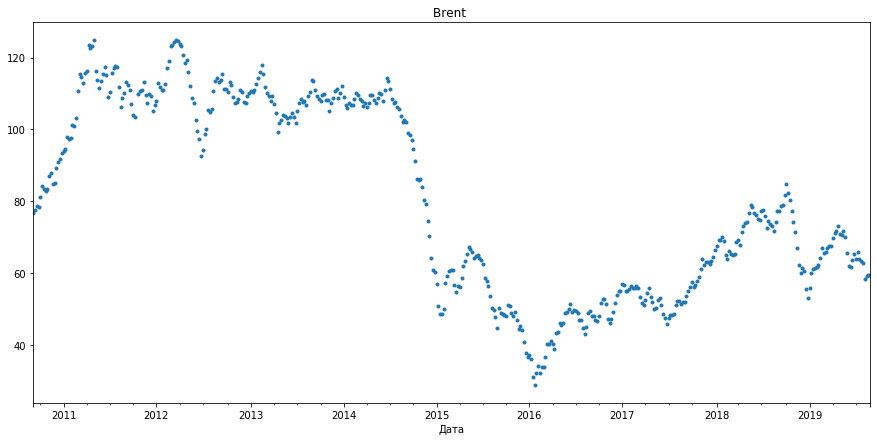

In [186]:
ind_anomal_brent_c= np.where(X_scale_clast ==-1)[0]  # индексы аномалий (наверное аномалий - будем смотреть)

ind_anomal_brent_c = np.array(ind_anomal_brent_c)+p+2  

_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(brent_data.iloc[ind_anomal_brent2].index,brent_data['Значение'].values[ind_anomal_brent2],'^g', label='BRENT anomaly stat')
plt.plot(brent_data.iloc[ind_anomal_brent_c].index,brent_data['Значение'].values[ind_anomal_brent_c],'or', label='BRENT anomaly claster')
plt.plot(brent_data.iloc[ind_anomal_brent].index,brent_data['Значение'].values[ind_anomal_brent],'+k', label='BRENT anomaly stat')
plt.legend()
plt.grid()
plt.ylabel('USA dollar')
plt.xlabel('t')


Построили несколько кандидатов на аномальное поведение. Попробуем определить какой-нибудь дополнительный способ анализа.

## Генерация признаков  из внешних источников

Естественным попутчиком любого финансово -ориентированного ряда является кросс-курс валют. В случае BRENT патриотично рассматриваем кросс-курс доллар-рубль (стоимость доллара в рублях) и евро-рубль (стоимость евро в рублях). Интервал измерения стоимости доллара и евро соответствует частоте и периоду нашего ряда "стоимость нефти", а источник данных https://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.FromDate=01.09.2010&UniDbQuery.ToDate=01.09.2019, который позволяет сохранить результаты в нескольких различных вариантах. Прочитаем, сохраненные данные.

In [187]:
rub_doll=pd.read_excel('RC_F01_09_2009_T01_09_2019 (1).xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll.head()



,curs
2009-09-01,31.8397
2009-09-02,31.7743
2009-09-03,31.9730
2009-09-04,31.7679
2009-09-05,31.6062


In [188]:
rub_e=pd.read_excel('RC_F01_09_2009_T01_09_2019.xlsx')
rub_e.index = pd.to_datetime(rub_e['data'].values).date
rub_e.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_e.head()

,curs
2009-09-01,45.4321
2009-09-02,45.6501
2009-09-03,45.4880
2009-09-04,45.3932
2009-09-05,45.1084


И сделаем их визуализацию.

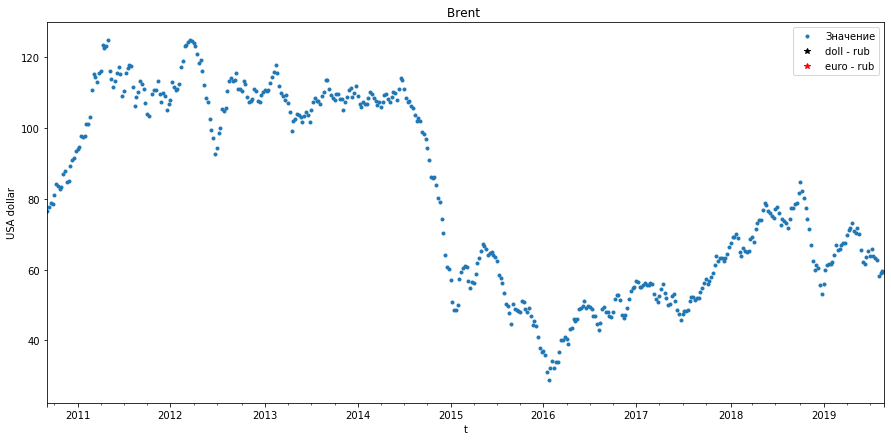

In [189]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(rub_doll.index,rub_doll['curs'].values,'*k', label='doll - rub')
plt.plot(rub_e.index,rub_e['curs'].values,'*r', label='euro - rub')
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.legend()
plt.show()

Посмотрим на первые разности. Помним, что для BRENT первые разности стационарны. Проверим как выглядят они для кросс-курсов.

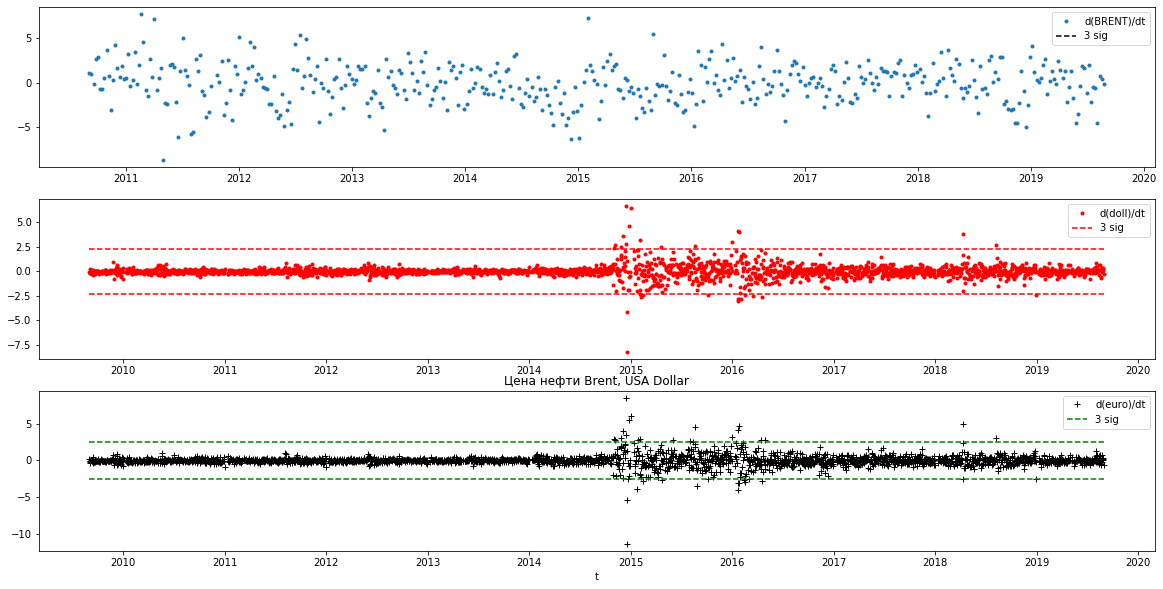

In [190]:
d_rub_doll = rub_doll['curs'].values[1:]- rub_doll['curs'].values[:-1]
s_rub = np.std(d_rub_doll)**0.5 *3

d_rub_e = rub_e['curs'].values[1:]- rub_e['curs'].values[:-1]
s_rube = np.std(d_rub_e)**0.5 *3

plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(brent_data.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.legend()

plt.subplot(3,1,2)
plt.plot(rub_doll.iloc[:-1].index,d_rub_doll,'.r', label='d(doll)/dt')
plt.plot(rub_doll.iloc[[0,-1]].index,[s_rub, s_rub],'--r',label ='3 sig')
plt.plot(rub_doll.iloc[[0,-1]].index,[-s_rub, -s_rub],'--r')
plt.legend()

plt.subplot(3,1,3)
plt.plot(rub_e.iloc[:-1].index,d_rub_e,'+k', label='d(euro)/dt')
plt.plot(rub_e.iloc[[0,-1]].index,[s_rube, s_rube],'--g',label ='3 sig')
plt.plot(rub_e.iloc[[0,-1]].index,[-s_rube, -s_rube],'--g')

plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent = np.where( abs(d_brent_data)>s_brent)[0]
ind_anomal_rubl_d = np.where( abs(d_rub_doll)>s_rub)[0]
ind_anomal_rubl_e = np.where( abs(d_rub_e)>s_rube)[0]

   


Сопоставим списки результатов, которые вышли за границы 3 сигма.

In [191]:
ind_anomal_brent

array([], dtype=int64)

In [192]:
ind_anomal_rubl_d

array([1286, 1288, 1304, 1306, 1315, 1316, 1317, 1319, 1324, 1327, 1344,
       1345, 1346, 1352, 1396, 1481, 1513, 1574, 1582, 1583, 1584, 1585,
       1586, 1592, 1602, 1619, 1642, 2130, 2213, 2315], dtype=int64)

In [193]:
ind_anomal_rubl_e

array([1286, 1288, 1304, 1306, 1315, 1316, 1317, 1319, 1324, 1327, 1336,
       1338, 1345, 1352, 1398, 1425, 1466, 1481, 1484, 1574, 1582, 1583,
       1584, 1585, 1586, 1599, 1602, 1609, 1641, 1642, 1651, 2130, 2213,
       2315], dtype=int64)

Есть пересечение всех трех множеств объект с номером 1335. Покажем этот и несколько соседних объектов (они сильно выпадают из ряда у кросс-курсов): 

In [194]:
rub_doll.index[[1333, 1334, 1335, 1336, 1337]]

Index([2015-01-20, 2015-01-21, 2015-01-22, 2015-01-23, 2015-01-24], dtype='object')

Проблема кросс-курса с рублем в том, что трудно сказать курс зависит от цены  нефти или цена от курса (но по логике экономики должен курс рубля зависеть от цены нефти). 2016 в январе курс к доллару составил 82 р (https://www.gazeta.ru/business/2016/01/20/8031815.shtml) на фоне резкого падения цены нефти (иранский фактор - сняли эмбарго на экспорт в начале января). Однако, если в некоторый день цена нефти и кросс-курс ведут себя разнонаправленно, то можно предположить. что это не глобальное явление, а некоторый случайный выброс. Декабрь 2015-январь 2016 - смена уровня , т.е. глобальное изменение ряда по типу аномалии "изменение характера (распределения) значений". В данном случае сильно изменяется средняя ряда.

Добавим стоимость валюты в рублях

In [195]:
brent_data['doll']=0
brent_data['doll'].values[1:396]=rub_doll['curs'].values[1:396]
brent_data=brent_data.iloc[:396,:]

In [196]:
brent_data['eur']=0
brent_data['eur'].values[1:396]=rub_e['curs'].values[1:396]
brent_data=brent_data.iloc[:396,:]

In [197]:
brent_data['rur/eur']=0
brent_data['rur/eur'].values[1:396]=(brent_data['Значение'].values[1:396]/brent_data['eur'].values[1:396]).astype('float32') 
brent_data=brent_data.iloc[:396,:]

In [198]:
brent_data['rur/usd']=0
brent_data['rur/usd'].values[1:396]=(brent_data['Значение'].values[1:396]/brent_data['doll'].values[1:396]).astype('float32') 
brent_data=brent_data.iloc[:396,:]

В итоге данные примут вид 

In [199]:
brent_data.iloc[100:115,:]


,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,...,t4,t3,t2,d4,d3,d2,doll,eur,rur/eur,rur/usd
Дата,,,,,,,,,,,,,,,,,,,,,
2012-08-05,105.630000,2012.0,7.666667,12.000000,3.0,214.666667,31.0,2.666667,0.000000,0.000000,...,98,100,105,0,0,0,30,42,2,3
2012-08-12,110.560000,2012.0,8.000000,8.666667,3.0,221.666667,32.0,2.666667,0.000000,0.000000,...,100,105,104,4,4,4,30,42,2,3
2012-08-19,113.390000,2012.0,8.000000,15.666667,3.0,228.666667,33.0,2.666667,0.000000,0.000000,...,105,104,105,2,2,2,30,42,2,3
2012-08-26,114.260000,2012.0,8.000000,22.666667,3.0,235.666667,34.0,2.666667,0.000000,0.000000,...,104,105,110,0,0,0,30,42,2,3
2012-09-02,113.250000,2012.0,8.166667,24.500000,3.0,242.666667,35.0,2.666667,0.000000,0.166667,...,105,110,113,-1,-1,-1,30,42,2,3
2012-09-09,113.686667,2012.0,9.000000,5.666667,3.0,249.666667,36.0,2.666667,0.166667,0.000000,...,110,113,114,0,0,0,29,41,2,3
2012-09-16,115.551667,2012.0,9.000000,12.666667,3.0,256.666667,37.0,2.666667,0.000000,0.000000,...,113,114,113,1,1,1,30,41,2,3
2012-09-23,111.140000,2012.0,9.000000,19.666667,3.0,263.666667,38.0,2.666667,0.000000,0.000000,...,114,113,113,-4,-4,-4,30,41,2,3
2012-09-30,111.103333,2012.0,9.000000,26.666667,3.0,270.666667,39.0,2.666667,0.000000,0.000000,...,113,113,115,0,0,0,30,41,2,3


# Добавляем первые разности по стоимости доллара и евро к рублю


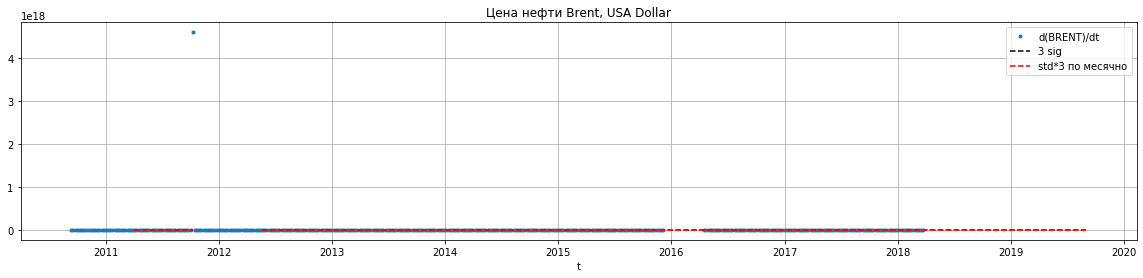

In [200]:
first_dif_eur_r = (brent_data['rur/eur'].values[1:]- brent_data['rur/eur'].values[:-1])/brent_data['rur/eur'].values[:-1]
first_dif_usd_r = (brent_data['rur/usd'].values[1:]- brent_data['rur/usd'].values[:-1])/brent_data['rur/usd'].values[:-1]
std_d_brent_e = pd.DataFrame(data=first_dif_eur_r,index =brent_data.index[1:] ).rolling(30).std()
s_brent1_e = np.std(first_dif_eur_r)*3 
plt.figure(figsize=(20,4))
plt.plot(brent_data.iloc[:-1].index,first_dif_eur_r,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent1, s_brent1],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent1, -s_brent1],'--k')
plt.plot(std_d_brent.index,std_d_brent*3,'--r',label = 'std*3 по месячно')
plt.plot(std_d_brent.index,-std_d_brent*3,'--r')
plt.xlabel('t')
plt.legend()
plt.grid()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()


## Выделение существенных признаков

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1) 

In [201]:
scl_target=StandardScaler() 

h=1
target = brent_data["Значение"].values[h:].reshape((brent_data.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(395, 1)

In [202]:
scl_x=StandardScaler() 

X = brent_data.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(395, 21)

Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. Таким образом, входной набор данных сформирован.

In [203]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())

for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Проверка через F-test показывает, что есть корреляционная связь с предшествующим значением ряда (признак X[:,0]), а кроме этого интересные признаки 1 , 7, 11, 12, 13 и 17. Применим автоматизацию выбора через SelectKBest c выделением 5 лучших признаков.

In [204]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Лучшее множество признаков отделенов X_new1. Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.

In [205]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Наконец, третий вариант - применим выделение признаков через построение модели . Помним , что модель должна уметь выбрать подмножество признаков или вернуть коэффициент их влиятельности. Это ограничивает выбор моделей. Возьмем как оценшик GradientBoostingRegressor и построим новое пространство в X_new3

In [206]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

Сравним результаты:


In [207]:
[X_new1[:5,:], X_new2[:5,:],X_new3[:5,:]]

[array([[-0.27057742, -2.94401205, -2.94377625, -2.94354051, -1.3014128 ],
        [-0.25201489, -2.94401205, -2.94377625, -2.94354051,  0.11611236],
        [-0.26343799, -2.94401205, -2.94377625, -2.94354051,  0.11611236],
        [-0.26165313, -2.94401205, -2.94377625, -2.94354051,  0.11611236],
        [-0.26129616, -2.94401205, -2.94377625, -2.94354051,  0.11611236]]),
 array([[-0.27057742, -2.94354051],
        [-0.25201489, -2.94354051],
        [-0.26343799, -2.94354051],
        [-0.26165313, -2.94354051],
        [-0.26129616, -2.94354051]]),
 array([[-0.27057742],
        [-0.25201489],
        [-0.26343799],
        [-0.26165313],
        [-0.26129616]])]

In [208]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

NotFittedError: This SelectKBest instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Пересечение выбора по отбору для модели и по количественным оценкам связи в признаке 0. Имеет смысл брать объединение выборов. Возьмем [0,6,14,21] признаки и перейдем к построению модели.

In [209]:
X_new = X[:,[0,11,12,13,17]]


## Разделение данных на тестовые и тренировочные 

Построение модели начинаем с выделения тестовой части нашего ряда. Напомним, что для временных рядов тест - непрерывная часть ряда не входившая в обучение (временные ряды 1). Будем отделять по индексу, который задаст дату разделения модели на тест и обучение.

In [210]:
# сделаем функцию
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

Для временного ряда "Потребление энергии" назначим датой разделения 100 от конца

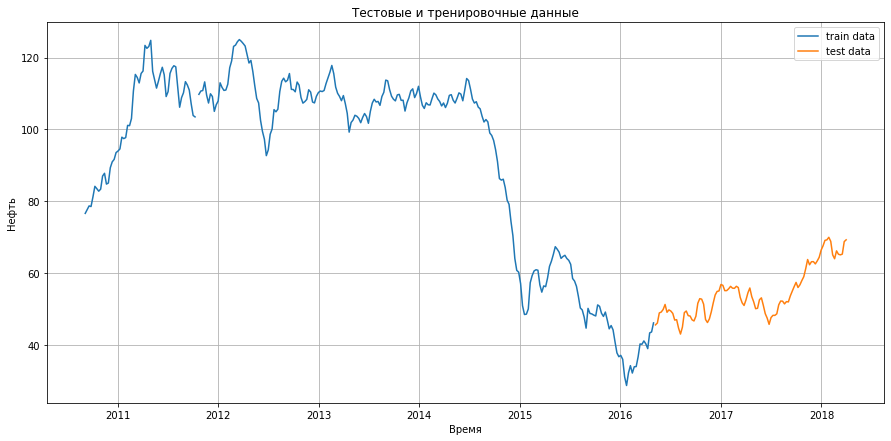

In [211]:
train, test = split_data( brent_data[-2000:], -100)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.grid()
plt.legend()
plt.show()

In [212]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [213]:
train.shape

(296, 21)

Выделим описание объекта и целевое свойство для тестовой и тренировочной частей ряда. Перейдем к построению моделей.  

# Строим Модель

При решении задачи на начальном этапе, самый интересный результат был получен на модели GradientBoostingRegressor. Остановимся на построении иенно такой формы предсказания. Импортируем необходимые модели.

In [214]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

Все модели возьмем в варианте параметров по умолчанию.

In [215]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=10, n_estimators=1000)
model_l = LinearRegression()

Запускаем модели и смотрим , что они построят на наших примерах.

In [216]:
model_l.fit( X_train, y_train ) # 
model_g.fit( X_train, y_train ) 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

**Посмотрим тесты**

In [217]:
X_test.shape

(99, 5)

In [218]:
y_pred_g = model_g.predict(X_train)
y_pred_l= model_l.predict(X_train)

y_test_pred_g = model_g.predict(X_test)
y_test_pred_l= model_l.predict(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

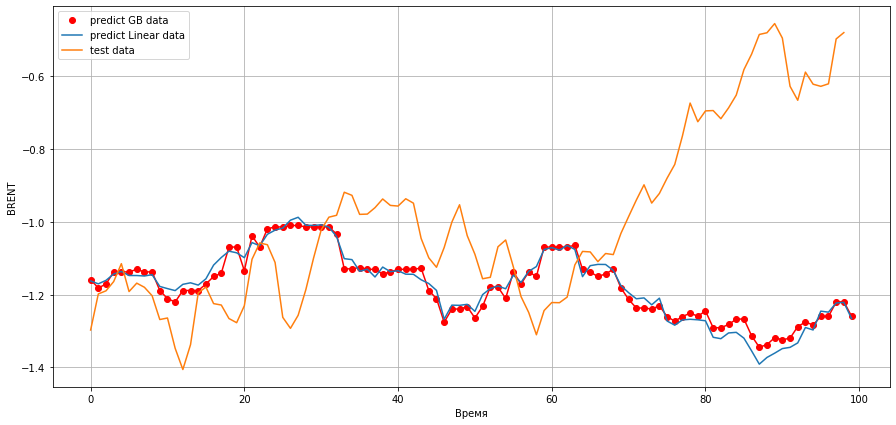

In [219]:

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g[:100],'or', label='predict GB data' )
plt.plot(y_test_pred_g[:100],'r' )
plt.plot(y_test_pred_l[:100], label='predict Linear data' )
plt.plot(y_test[:100], label='test data')
plt.grid()
plt.legend()
plt.show()

y_pred_g = model_g.predict(X_train)
y_pred_l= model_l.predict(X_train)

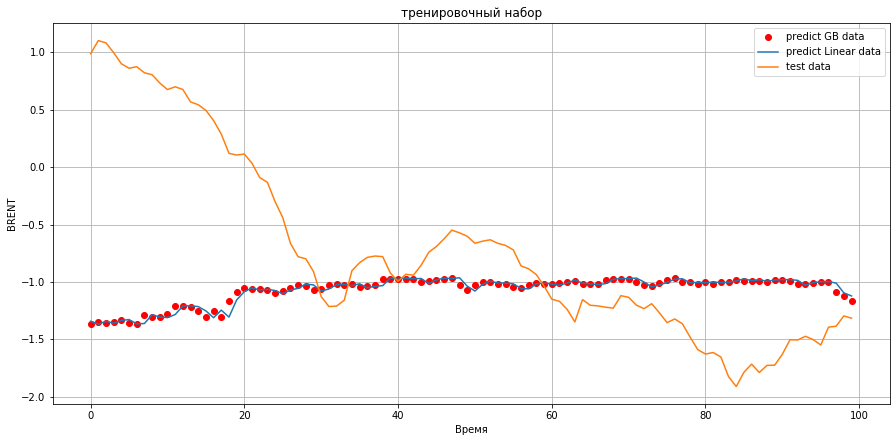

In [220]:
plt.figure( figsize=( 15, 7 ))

plt.title('тренировочный набор')
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_pred_g[-100:],'or', label='predict GB data' )
plt.plot(y_pred_l[-100:], label='predict Linear data' )
plt.plot(y_train[-100:], label='test data')
plt.grid()
plt.legend()
plt.show()

Линейная модель практически не работает, т.к. видно запаздывание в размере h.Градиентный бустинг практически не отличается от нее на интервале обучения. Посмотрим на оценки.

**Оценки для сравнения моделей**

In [221]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [222]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ValueError: Found input variables with inconsistent numbers of samples: [99, 328]

Абсолютная процентная ошибка (MAPE).Обратите внимание, что определять ее для масштабированной переменной не верно. Поэтому переведем ответ решателя обратно в состояние без масштаба.

In [223]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [224]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ValueError: operands could not be broadcast together with shapes (99,) (328,) 

In [225]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [226]:
model_g_best = GradientBoostingRegressor(max_depth=3,  n_estimators=300)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

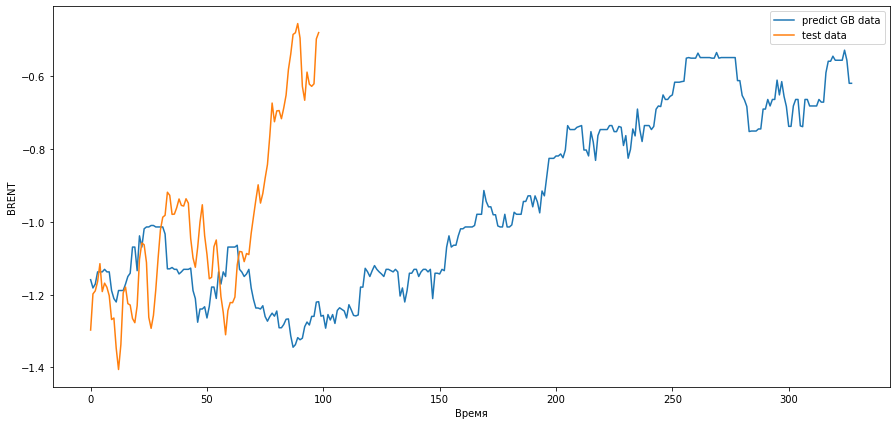

In [227]:

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g, label='predict GB data' )
plt.plot(y_test, label='test data')

plt.legend()
plt.show()

## Сохраниение модели

In [228]:
import pickle
# save the model to disk
filename = 'final_model_brent.sav'
pickle.dump(model_g_best, open(filename, 'wb'))

filename = 'final_scaler_brent_y.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_brent_x.sav'
pickle.dump(scl_x, open(filename, 'wb'))


## Заключение

Прогнозирование на основе обучения позволяет эффективно описывать достаточно сложные данные. Построение прогноза на основе генерации регрессионных моделей позволит построить хороший ответ даже не зная как устроен ряд и каковы его статистические свойства. При решении задачи прогнозирования следует учитывать следующие особенности этого подхода:
- Строим много признаков.
- Обрабатываем признаки и используем результаты статистического анализа ряда для придумывания новых признаков.
- Строим много моделей и не забываем, что тестирование моделей идет только на последних точках ряда.
- Используем правильные метрики.
- Следим за аномалиями



## Задание

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 
4. Постройте модель предсказания 1-й точки от текущей (h=1).

5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.